Dataset shape: (284807, 31)

Class distribution:
0    0.998273
1    0.001727
Name: Class, dtype: float64


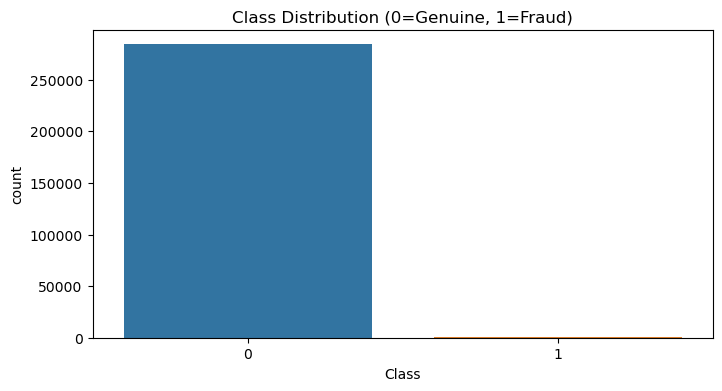

Training SVM...
[LibLinear]Training completed in 2.38 seconds


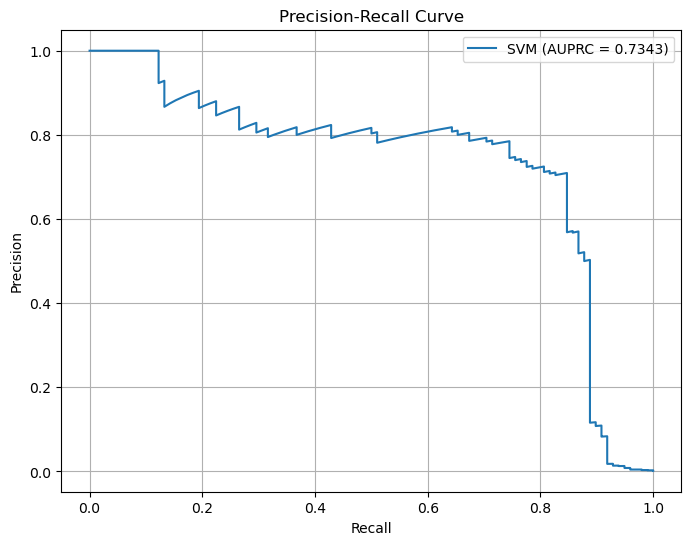


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.92      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



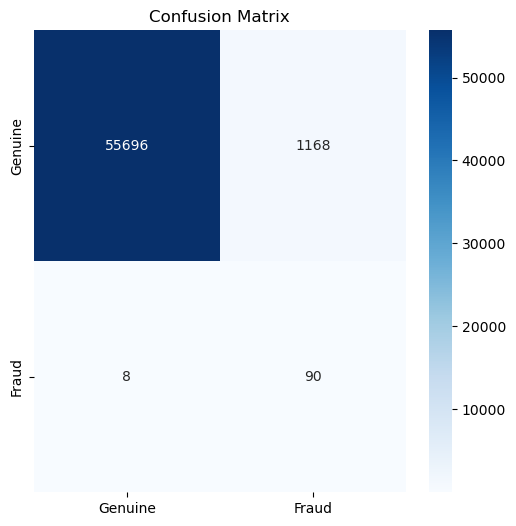

,Training Time (s),AUPRC Score,Recall (Fraud),Precision (Fraud)
Algorithm,,,,
Linear SVM,2.38,0.7343,1.0,0.0017


In [1]:
# %% [markdown]
"""
# Credit Card Fraud Detection using SVM
**Course:** Machine Learning – Programming Assignment  
**Dataset:** Credit Card Fraud Detection (https://www.kaggle.com/mlg-ulb/creditcardfraud)  
**Algorithm:** Support Vector Machine (SVM)  
**Evaluation Metric:** AUPRC (Area Under Precision-Recall Curve)  
**Team Member:** [Your Name]  
"""
# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (precision_recall_curve, 
                            average_precision_score, 
                            classification_report,
                            confusion_matrix)
from sklearn.utils import resample
import seaborn as sns
import time
import joblib  # For model saving

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %% [markdown]
"""
## 1. Data Loading and Exploration
"""
# %%
# Load dataset
df = pd.read_csv('creditcard.csv')  # Update path as needed

# Check class distribution
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))

# Visualize class imbalance
plt.figure(figsize=(8, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0=Genuine, 1=Fraud)')
plt.show()

# %% [markdown]
"""
## 2. Data Preprocessing
"""
# %%
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split (stratified to maintain class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Scale features (critical for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %% [markdown]
"""
## 3. Model Training - SVM with Class Weight Balancing
"""
# %%
# Initialize Linear SVM (faster than SVC for linear kernels)
svm_model = LinearSVC(
    class_weight='balanced',  # Handle class imbalance
    dual=False,              # Faster when n_samples > n_features
    max_iter=1000,           # Ensure convergence
    random_state=RANDOM_STATE,
    verbose=1                # Show training progress
)

# Train model with timing
print("Training SVM...")
start_time = time.time()
svm_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Save model for reproducibility
joblib.dump(svm_model, 'svm_fraud_detector.pkl')

# %% [markdown]
"""
## 4. Evaluation on Test Set
"""
# %%
# Get decision function scores (since LinearSVC doesn't have predict_proba)
y_scores = svm_model.decision_function(X_test_scaled)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auprc = average_precision_score(y_test, y_scores)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'SVM (AUPRC = {auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Classification report at default threshold
y_pred = svm_model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Genuine', 'Fraud'], 
            yticklabels=['Genuine', 'Fraud'])
plt.title('Confusion Matrix')
plt.show()

# %% [markdown]
"""
## 5. Results Summary
"""
# %%
results = {
    "Algorithm": "Linear SVM",
    "Training Time (s)": round(training_time, 2),
    "AUPRC Score": round(auprc, 4),
    "Recall (Fraud)": round(recall[1], 4),  # Recall at default threshold
    "Precision (Fraud)": round(precision[1], 4)
}

pd.DataFrame([results]).set_index("Algorithm")